# Extraer espetrogramas

In [1]:
import torch
from torch import nn, optim
from torchvision import transforms, datasets, utils
from PIL import Image
import numpy as np
import math
from IPython.display import display
from tqdm import tqdm
from itertools import cycle
from typing import Tuple

%pip install opencv-python librosa numpy matplotlib
%pip install ipywidgets
import cv2
import librosa
import matplotlib.pyplot as plt
import os
from torch.utils.data import Dataset, DataLoader

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [2]:
seed = 123
np.random.seed(seed)
_ = torch.manual_seed(seed)
_ = torch.cuda.manual_seed(seed)

In [3]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

**Defining the Hyper-parameters**

We now define the hyperparameters that are going to be used throughout the notebook to define the network.


In [4]:
hparams = {
    'batch_size':32,
    'num_epochs':10,
    'learning_rate':0.0002,
    'betas':(0.5, 0.999),
    'noise_size':64*64,
    'num_val_samples':25,
    'num_classes':10,
    'num_input_channels':3,
}

### Dataset and Data Loader
Download and prepare dataset and datalaoder


In [71]:
import os
from torch.utils.data import Dataset, DataLoader

# Change directory to the folder containing the videos
os.chdir('C:/Users/David/Documents/postgrau/Projecte/raining')

# Get a list of all .mp4 files in the folder
video_files = [f for f in os.listdir('.') if f.endswith('.mp4')]

# Create the 'frames' directory if it doesn't exist
if not os.path.exists('frames'):
    os.makedirs('frames')

# Change directory to the folder containing the videos
os.chdir('C:/Users/David/Documents/postgrau/Projecte/raining')

# Get a list of all .mp4 files in the folder
video_files = [f for f in os.listdir('.') if f.endswith('.mp4')]

# Create the 'frames' directory if it doesn't exist
if not os.path.exists('frames'):
    os.makedirs('frames')

# Loop through each video file
for video_file in video_files:
    # Load the video
    cap = cv2.VideoCapture(video_file)

    # Initialize frame and spectrogram lists
    frames = []
    spectrograms = []

    # Get the total duration of the video
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    fps = cap.get(cv2.CAP_PROP_FPS)
    total_duration = total_frames / fps

    # Extract frames and spectrograms
    frame_time = 0  # initialize frame time to 0
    while True:
        ret, frame = cap.read()
        if not ret:
            break

        # Resize frame to 128x128
        frame = cv2.resize(frame, (128, 128))

        # Extract audio and convert to spectrogram
        # Load a short segment of audio centered around the current frame

        # Pad the audio appropriately for the first and last frames
        if frame_time < 0.5:
            # For the first frames, load audio from the start and pad the beginning
            padding_duration = 0.5 - frame_time
            y, sr = librosa.load(video_file, sr=None, offset=0, duration=frame_time + 0.5)
            y_padded = np.pad(y, (int(sr * padding_duration), 0), 'constant')
        elif frame_time > total_duration - 0.5:
            # For the last frames, load audio from the end and pad the end
            padding_duration = 0.5 - (total_duration - frame_time)
            audio_offset = frame_time - 0.5
            y, sr = librosa.load(video_file, sr=None, offset=audio_offset, duration= 1- padding_duration)
            y_padded = np.pad(y, (0, int(sr * padding_duration)), 'constant')
        else:
            # For all other frames, load 1 second of audio as before
            y, sr = librosa.load(video_file, sr=None, offset=frame_time - 0.5, duration=1)
            y_padded = y

        win_length = 256  # window length in samples
        hop_length = 64  # hop length in samples
        D = librosa.amplitude_to_db(np.abs(librosa.stft(y_padded, win_length=win_length, hop_length=hop_length)), ref=np.max)

        # Resize spectrogram to 128x128
        D = cv2.resize(D, (128, 128))

        spectrograms.append(D)

        # Save frame and spectrogram to the 'frames' directory using the frame time as the filename
        frame_filename = 'frames/{}_{:.3f}_frame.npy'.format(video_file.split('.')[0], frame_time)
        spectrogram_filename = 'frames/{}_{:.3f}_spectrogram.npy'.format(video_file.split('.')[0], frame_time)
        np.save(frame_filename, frame)
        np.save(spectrogram_filename, spectrograms[-1])

        frames.append(frame)
        frame_time += 1 / fps  # increment frame time by the duration of one frame

    cap.release()



C:\Users\David\AppData\Local\Temp\ipykernel_4788\1665502118.py:55: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(video_file, sr=None, offset=0, duration=frame_time + 0.5)
C:\Users\David\AppData\Local\Temp\ipykernel_4788\1665502118.py:65: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(video_file, sr=None, offset=frame_time - 0.5, duration=1)
C:\Users\David\AppData\Local\Temp\ipykernel_4788\1665502118.py:61: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(video_file, sr=None, offset=audio_offset, duration= 1- padding_duration)


In [72]:
# Change directory to the folder containing the frames and spectrograms
os.chdir('C:/Users/David/Documents/postgrau/Projecte/raining/frames')

# Define custom dataset class
class FrameSpectrogramDataset(Dataset):
    def __init__(self, root_dir):
        self.root_dir = root_dir
        self.frame_files = [f for f in os.listdir(root_dir) if f.endswith('_frame.npy')]

    def __len__(self):
        return len(self.frame_files)

    def __getitem__(self, idx):
        frame_file = self.frame_files[idx]
        frame = np.load(os.path.join(self.root_dir, frame_file))
        spectrogram_file = frame_file.replace('_frame.npy', '_spectrogram.npy')
        spectrogram = np.load(os.path.join(self.root_dir, spectrogram_file))

        # Convert numpy arrays to PyTorch tensors with the same data type
        frame = torch.from_numpy(frame.astype(np.float32))
        spectrogram = torch.from_numpy(spectrogram.astype(np.float32))

        # Normalize frame to the range [0, 1]
        frame = frame / frame.max()

        return frame, spectrogram


# Create a dataset
dataset = FrameSpectrogramDataset('.')

# Create a DataLoader
dataloader = DataLoader(
    dataset,
    batch_size=hparams['batch_size'],
    shuffle=False,
)

In [73]:
dataset = FrameSpectrogramDataset('.')
print(len(dataset))

8300


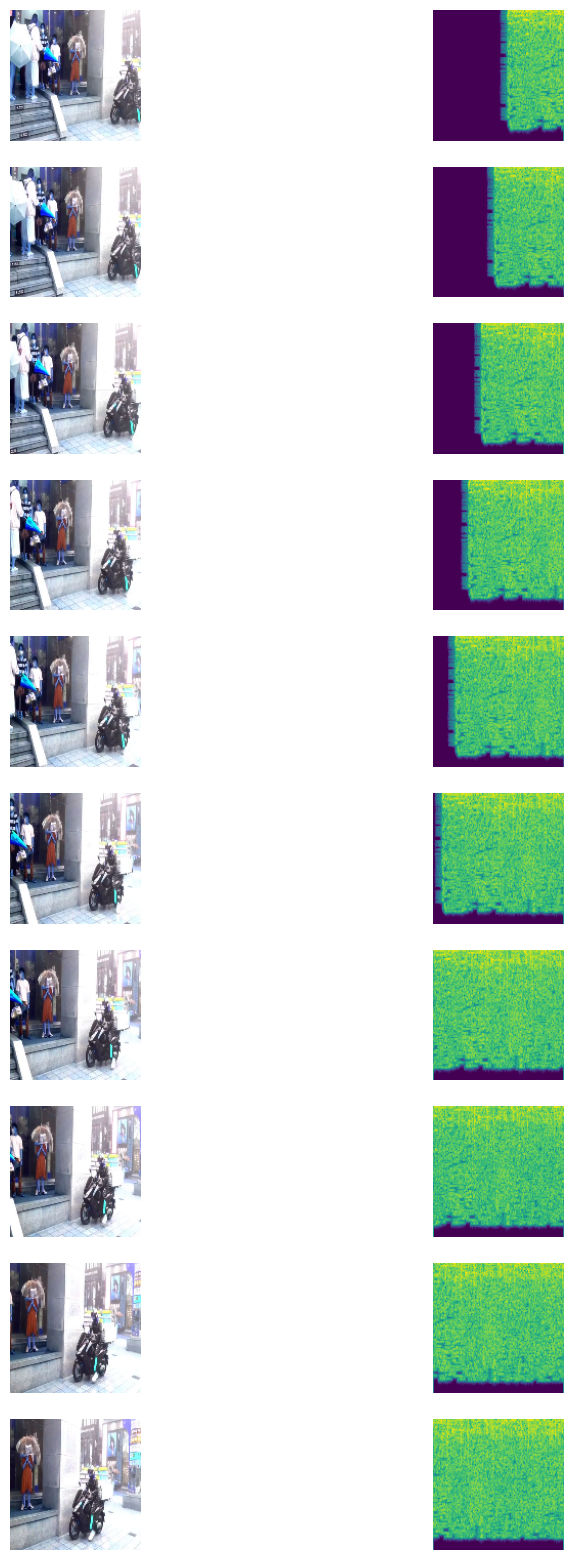

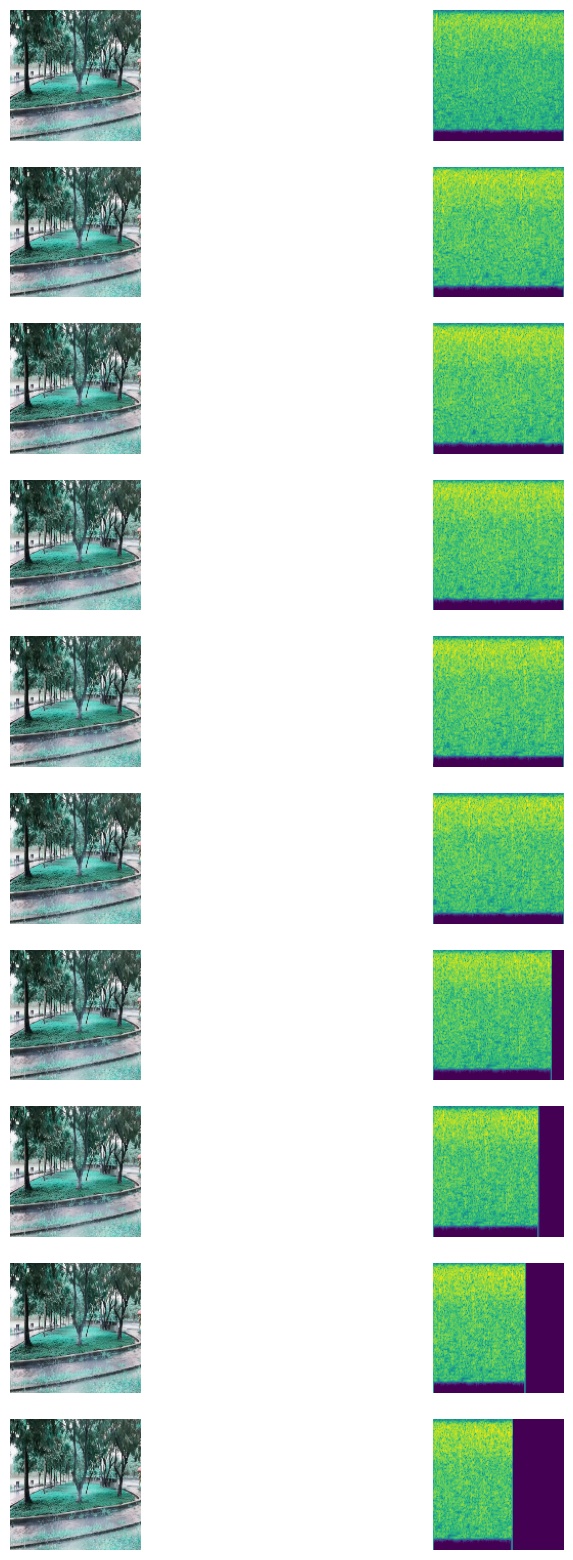

In [74]:
import matplotlib.pyplot as plt

# Get the first 10 pairs of data from the dataset
first_10_pairs = [dataset[i] for i in range(10)]

# Get the last 10 pairs of data from the dataset
last_10_pairs = [dataset[i] for i in range(-10, 0)]

# Plot the first 10 pairs of data
fig, axs = plt.subplots(10, 2, figsize=(10, 20))
for i, (frame, spectrogram) in enumerate(first_10_pairs):
    axs[i, 0].imshow(frame.numpy(), cmap='gray')
    axs[i, 1].imshow(spectrogram.numpy(), cmap='viridis')
    axs[i, 0].axis('off')
    axs[i, 1].axis('off')

# Plot the last 10 pairs of data
fig, axs = plt.subplots(10, 2, figsize=(10, 20))
for i, (frame, spectrogram) in enumerate(last_10_pairs):
    axs[i, 0].imshow(frame.numpy(), cmap='gray')
    axs[i, 1].imshow(spectrogram.numpy(), cmap='viridis')
    axs[i, 0].axis('off')
    axs[i, 1].axis('off')

plt.show()